In [16]:
# package imports
import argparse
from typing import List, Tuple
import cv2
from ultralytics import YOLO
import supervision as sv
import numpy as np

BASE_DIR = ""
VIDEO_PATH = "../data/vehicle-counting.mp4"
MODEL_PATH = ""
model_type = "small"
if model_type == "large":
    MODEL_PATH = "../models/yolov8l.pt"
else:   
    MODEL_PATH = "../models/yolov8s.pt"

In [17]:
# Set model
model = YOLO(MODEL_PATH)

In [ ]:
# Left lane dotted
[
np.array([
[1596, 613],[972, 2121]
])
]
    
# Right lane dotted
[
np.array([
[1596, 613],[972, 2121]
])
]

# Right lane boundary 
[
np.array([
[1872, 769],[2860, 2145],[3772, 2145],[3832, 2121],[3828, 1801],[2072, 749],[1884, 753]
])
]

# left lane boundary 
[
np.array([
[1684, 717],[1452, 713],[172, 2149],[1756, 2145],[1684, 693]
])
]

def initiate_polygon_zones(
    polygons: List[np.ndarray],
    frame_resolution_wh: Tuple[int, int], 
    triggering_position: sv.Position, 
)->List[sv.PolygonZone]:
    return [
        sv.PolygonZone(
        polygon=polygon,
        frame_resolution_wh=frame_resolution_wh,
        triggering_position=triggering_position,
        ) for polygon in polygons
    ]



In [47]:
import argparse
class VideoProcessor: 
    def __init__(
        self, 
        source_weights_path:str, 
        source_video_path:str,
        target_video_path:str, 
        confidence_threshold:float=0.3, 
        iou_threshold:float=0.7,
    )->None:
        print(f"Source weights path: {source_weights_path}")
        print(f"Source video path: {source_video_path}")
        print(f"Target video path: {target_video_path}")
        print(f"Confidence threshold: {confidence_threshold}")
        print(f"IoU threshold: {iou_threshold}")
        
    def process_video(self):
        pass

    def annotate_frame(self, frame: np.ndarray, detections: sv.Detections)->np.ndarray:
        pass

    def process_frame(self, frame: np.ndarray)->np.ndarray:
        pass

if __name__ == "__main__":
    parser = argparse.ArgumentParser(
        description="Vehicle counting"
    )
    
    parser.add_argument(
        "--source_weights_path",
        required=True,  
        type=str,
    )
    
    parser.add_argument(
        "--source_video_path",
        required=True,
        type=str,)
    
    parser.add_argument(
        "--target_video_path",
        required=True,
        type=str,)
    
    parser.add_argument(
        "--confidence_threshold", 
        required=False,
        type=float,
    )
    
    parser.add_argument(
        "--iou_threshold",
        type=float, 
    )
    
    args = parser.parse_args()
    processor = VideoProcessor(
        source_weights_path=args.source_weights_path,
        source_video_path=args.source_video_path,
        target_video_path=args.target_video_path,
        confidence_threshold=args.confidence_threshold,
        iou_threshold=args.iou_threshold,
    )
    
    processor.process_video()
        

usage: ipykernel_launcher.py [-h] --source_weights_path SOURCE_WEIGHTS_PATH
                             --source_video_path SOURCE_VIDEO_PATH
                             --target_video_path TARGET_VIDEO_PATH
                             [--confidence_threshold CONFIDENCE_THRESHOLD]
                             [--iou_threshold IOU_THRESHOLD]
ipykernel_launcher.py: error: the following arguments are required: --source_weights_path, --source_video_path, --target_video_path


SystemExit: 2

/Users/dloader/miniforge3/envs/traffic-env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3556: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [5]:
# Get video information
video_info = sv.VideoInfo.from_video_path(VIDEO_PATH)

# Frame generator obj
frames_generator = sv.get_video_frames_generator(VIDEO_PATH)

In [8]:
iterator = iter(frames_generator)
    

In [11]:
frame = next(iterator)
frame.shape

(2160, 3840, 3)

In [12]:
from matplotlib import pyplot as plt

In [42]:
def show_frame(frame:np.ndarray)->None:
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    return None

In [19]:
results = model(frame)[0]
print(results.boxes.xyxy)


0: 384x640 4 cars, 1 truck, 77.3ms
Speed: 2.7ms preprocess, 77.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


tensor([[2919.7253, 1259.1577, 3207.5935, 1481.7169],
        [1433.1614, 1088.3053, 1618.8832, 1239.7339],
        [ 936.6744,  898.7036, 1240.9872, 1307.3031],
        [1487.2117, 1009.8607, 1619.3724, 1078.9958],
        [1482.4290, 1009.2012, 1624.1464, 1126.7594]])


In [20]:
print(results.boxes.cls)

tensor([2., 2., 7., 2., 2.])


In [39]:
from supervision import Detections, BoxAnnotator
from supervision import ColorPalette

box_annotator = BoxAnnotator(thickness=4, text_thickness=4, text_scale=2) 

detections = Detections(
    xyxy= results.boxes.xyxy.cpu().numpy(),
    confidence=results.boxes.conf.cpu().numpy(),
    class_id=results.boxes.cls.cpu().numpy().astype(int),
)

labels = [
    f"{model.model.names[class_id]} {confidence:.02f}" for _, _, confidence, class_id, _ in detections
]

In [40]:
frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)

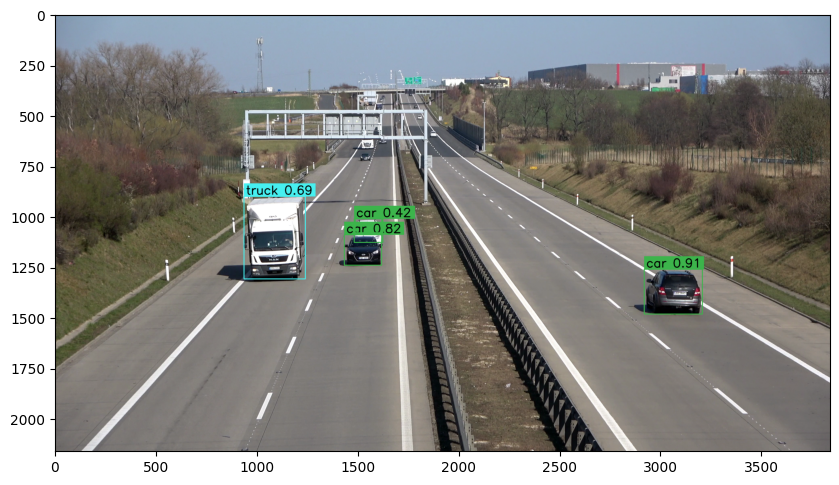

In [43]:
show_frame(frame)

# Detections on full video

In [45]:
# Create instance of ByteTracker
tracker = sv.ByteTrack()

In [46]:
# Loop over video 
def process_frame(frame:np.ndarray, i) -> np.ndarray:
    results = model(frame, imgsz=1280, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    
    detections = tracker.update(detections=detections)
    for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
        mask = zone.trigger(detections=detections)
        detections_filtered = detections[mask]
            
        labels = [
            f"{model.model.names[class_id]} {confidence:.02f}" 
            for _, _, confidence, class_id, _ 
            in detections_filtered
        ]
        frame = box_annotator.annotate(scene=frame, 
                                       detections=detections_filtered,
                                       labels=labels)
        frame = zone_annotator.annotate(scene=frame)
            
    return frame